In [1]:
import gym
import numpy as np
import random
# import tensorflow as tf
# from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import deque

Using TensorFlow backend.


In [2]:
class DeepQN:
    def __init__(self, env):
        self.env = env
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / 50000
        self.batch_size = 64
        self.train_start = 1000
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.learning_rate = 0.001
        self.model = self.create_model()
        self.target_model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Dense(
            32, input_dim=self.state_size, activation='relu', kernel_initializer="he_uniform"))
        model.add(Dense(16, activation='relu', kernel_initializer="he_uniform"))
        model.add(Dense(self.env.action_space.n, activation="linear",
                        kernel_initializer="he_uniform"))
        model.compile(
            loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))
        return model

    def act(self, state):
        # Decay exploration rate by epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        if len(self.memory) < self.train_start:
            return

        mini_batch = random.sample(self.memory, self.batch_size)

        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.action_size))

        for i in range(self.batch_size):
            state, action, reward, next_state, done = mini_batch[i]
            target = self.model.predict(state)[0]

            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * \
                    np.amax(self.target_model.predict(next_state)[0])
            update_input[i] = state
            update_target[i] = target

        self.model.fit(update_input, update_target,
                       batch_size=self.batch_size, epochs=1, verbose=0)

    def target_train(self):
        # Simply copy the weights of the model to target_model
        self.target_model.set_weights(self.model.get_weights())
        return

    def save_model(self, fn):
        self.model.save(fn)

In [3]:
env = gym.make("MountainCar-v0")
trials = 600
trial_len = 200
all_rewards = []
best_score = 200
best_weights = None
agent = DeepQN(env=env)
best_model = agent.create_model()

In [4]:
for trial in range(trials):
  cur_state = env.reset().reshape(1, 2)
  for step in range(trial_len):
      action = agent.act(cur_state)
      new_state, reward, done, _ = env.step(action)

      new_state = new_state.reshape(1, 2)
      agent.remember(cur_state, action, reward, new_state, done)

      agent.replay()

      cur_state = new_state
      if done:
          env.reset()
          agent.target_train()
          break
  if step+1 < best_score:
    best_score = step+1
    best_weights = agent.model.get_weights()

  all_rewards.append(step+1)

  print("Iteration: {} Score: -{}".format(trial, step+1))

Iteration: 0 Score: -200
Iteration: 1 Score: -200
Iteration: 2 Score: -200
Iteration: 3 Score: -200
Iteration: 4 Score: -200
Iteration: 5 Score: -200
Iteration: 6 Score: -200
Iteration: 7 Score: -200
Iteration: 8 Score: -200
Iteration: 9 Score: -200
Iteration: 10 Score: -200
Iteration: 11 Score: -200
Iteration: 12 Score: -200
Iteration: 13 Score: -200
Iteration: 14 Score: -200
Iteration: 15 Score: -200
Iteration: 16 Score: -200
Iteration: 17 Score: -200
Iteration: 18 Score: -200
Iteration: 19 Score: -200
Iteration: 20 Score: -200
Iteration: 21 Score: -200
Iteration: 22 Score: -200
Iteration: 23 Score: -200
Iteration: 24 Score: -200
Iteration: 25 Score: -200
Iteration: 26 Score: -200
Iteration: 27 Score: -200
Iteration: 28 Score: -200
Iteration: 29 Score: -200
Iteration: 30 Score: -200
Iteration: 31 Score: -200
Iteration: 32 Score: -200
Iteration: 33 Score: -200
Iteration: 34 Score: -200
Iteration: 35 Score: -200
Iteration: 36 Score: -200
Iteration: 37 Score: -200
Iteration: 38 Score: -

Iteration: 308 Score: -99
Iteration: 309 Score: -136
Iteration: 310 Score: -148
Iteration: 311 Score: -142
Iteration: 312 Score: -137
Iteration: 313 Score: -128
Iteration: 314 Score: -146
Iteration: 315 Score: -134
Iteration: 316 Score: -153
Iteration: 317 Score: -155
Iteration: 318 Score: -152
Iteration: 319 Score: -149
Iteration: 320 Score: -155
Iteration: 321 Score: -163
Iteration: 322 Score: -84
Iteration: 323 Score: -116
Iteration: 324 Score: -115
Iteration: 325 Score: -136
Iteration: 326 Score: -97
Iteration: 327 Score: -123
Iteration: 328 Score: -121
Iteration: 329 Score: -109
Iteration: 330 Score: -123
Iteration: 331 Score: -120
Iteration: 332 Score: -117
Iteration: 333 Score: -116
Iteration: 334 Score: -108
Iteration: 335 Score: -135
Iteration: 336 Score: -125
Iteration: 337 Score: -125
Iteration: 338 Score: -121
Iteration: 339 Score: -147
Iteration: 340 Score: -119
Iteration: 341 Score: -116
Iteration: 342 Score: -120
Iteration: 343 Score: -113
Iteration: 344 Score: -91
Itera

In [21]:
agent.model.save("original_mlp1.h5")

In [6]:
if best_weights != None:
    best_model.set_weights(best_weights)
    best_model.save("best_mlp1.h5")

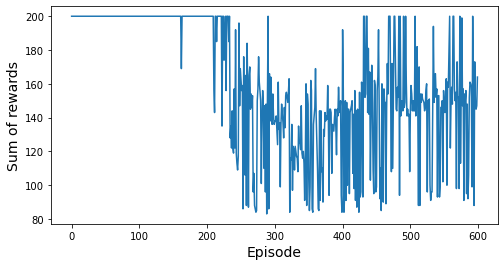

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(all_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [8]:
first_win = -1
for i,value in enumerate(all_rewards):
  if value < 200:
    first_win = i
    break

In [9]:
print("mean reward: ",np.mean(all_rewards),", best reward:",np.min(all_rewards),", first win episode:",first_win)

mean reward:  162.00833333333333 , best reward: 83 , first win episode: 162


# **Test**

In [12]:
# env = gym.make("MountainCar-v0")
import keras

loaded_model = keras.models.load_model('best_mlp1.h5')

trials = 100
trial_len = 200
all_rewards_test = []
for trial in range(trials):
    cur_state = env.reset().reshape(1, 2)
    for step in range(trial_len):
        action = np.argmax(loaded_model.predict(cur_state)[0])
        cur_state, reward, done, _ = env.step(action)
        cur_state = cur_state.reshape(1, 2)
        if done:
            env.reset()
            break
    all_rewards_test.append(step+1)
    print("Iteration: {} Score: -{}".format(trial, step+1))

Iteration: 0 Score: -88
Iteration: 1 Score: -158
Iteration: 2 Score: -156
Iteration: 3 Score: -88
Iteration: 4 Score: -86
Iteration: 5 Score: -200
Iteration: 6 Score: -92
Iteration: 7 Score: -96
Iteration: 8 Score: -200
Iteration: 9 Score: -160
Iteration: 10 Score: -88
Iteration: 11 Score: -200
Iteration: 12 Score: -85
Iteration: 13 Score: -90
Iteration: 14 Score: -164
Iteration: 15 Score: -200
Iteration: 16 Score: -95
Iteration: 17 Score: -89
Iteration: 18 Score: -160
Iteration: 19 Score: -153
Iteration: 20 Score: -169
Iteration: 21 Score: -164
Iteration: 22 Score: -101
Iteration: 23 Score: -158
Iteration: 24 Score: -153
Iteration: 25 Score: -200
Iteration: 26 Score: -184
Iteration: 27 Score: -200
Iteration: 28 Score: -161
Iteration: 29 Score: -200
Iteration: 30 Score: -200
Iteration: 31 Score: -155
Iteration: 32 Score: -200
Iteration: 33 Score: -153
Iteration: 34 Score: -95
Iteration: 35 Score: -102
Iteration: 36 Score: -170
Iteration: 37 Score: -154
Iteration: 38 Score: -93
Iteratio

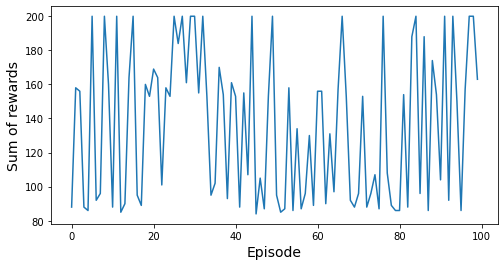

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(all_rewards_test)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [14]:
print("mean reward: ",np.mean(all_rewards_test),", best reward:",np.min(all_rewards_test),", first win episode:",np.argmin(all_rewards_test))

mean reward:  135.96 , best reward: 84 , first win episode: 45


In [18]:
# env = gym.make("MountainCar-v0")
import keras

loaded_model = keras.models.load_model('original_mlp1.h5')

trials = 200
trial_len = 200
all_rewards_test = []
for trial in range(trials):
    cur_state = env.reset().reshape(1, 2)
    for step in range(trial_len):
        action = np.argmax(loaded_model.predict(cur_state)[0])
        cur_state, reward, done, _ = env.step(action)
        cur_state = cur_state.reshape(1, 2)
        if done:
            env.reset()
            break
    all_rewards_test.append(step+1)
    print("Iteration: {} Score: -{}".format(trial, step+1))

Iteration: 0 Score: -159
Iteration: 1 Score: -164
Iteration: 2 Score: -154
Iteration: 3 Score: -155
Iteration: 4 Score: -86
Iteration: 5 Score: -148
Iteration: 6 Score: -155
Iteration: 7 Score: -156
Iteration: 8 Score: -154
Iteration: 9 Score: -90
Iteration: 10 Score: -159
Iteration: 11 Score: -151
Iteration: 12 Score: -154
Iteration: 13 Score: -155
Iteration: 14 Score: -156
Iteration: 15 Score: -148
Iteration: 16 Score: -94
Iteration: 17 Score: -156
Iteration: 18 Score: -149
Iteration: 19 Score: -160
Iteration: 20 Score: -148
Iteration: 21 Score: -91
Iteration: 22 Score: -153
Iteration: 23 Score: -154
Iteration: 24 Score: -160
Iteration: 25 Score: -155
Iteration: 26 Score: -160
Iteration: 27 Score: -95
Iteration: 28 Score: -162
Iteration: 29 Score: -153
Iteration: 30 Score: -85
Iteration: 31 Score: -156
Iteration: 32 Score: -153
Iteration: 33 Score: -158
Iteration: 34 Score: -154
Iteration: 35 Score: -149
Iteration: 36 Score: -89
Iteration: 37 Score: -95
Iteration: 38 Score: -148
Iter

In [19]:
print("mean reward: ",np.mean(all_rewards_test),", best reward:",np.min(all_rewards_test),", first win episode:",np.argmin(all_rewards_test))

mean reward:  133.305 , best reward: 85 , first win episode: 30


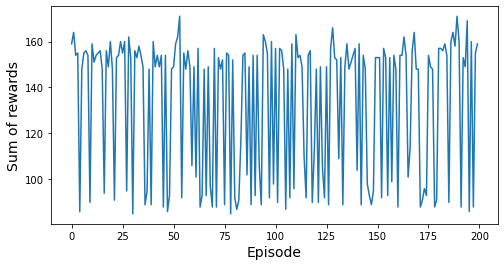

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(all_rewards_test)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()